## Fraud Detection

This notebook presents an implementation of machine learning model for Fraud Detection on financial dataset. The main focus is to develop a robust model for anamoly detection with high efficency.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

Content of the notebook:
- 1. Read Data
- 2. Exploratory Data Analysis
- 3. Data Preprocessing
- 4. Model Development
  - 4.1 Decision Tree
  - 4.2 Synthetic Minority Oversampling Technique (SMOTE)
- 5. Results
- 6. Discussion

Import the necessary libraries for data analysis and visualization.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 1. Read Data

In [2]:
paysim = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [3]:
paysim.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


- step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount: amount of the transaction in local currency.

- nameOrig: customer who started the transaction

- oldbalanceOrg: initial balance before the transaction

- newbalanceOrig: new balance after the transaction.

- nameDest: customer who is the recipient of the transaction

- oldbalanceDest: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



## 2. Exploratory Data Analysis

In [4]:
paysim.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Check for missing value.

In [5]:
paysim.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
print('Number of unique values/Categories:')
for col in paysim.columns:
    print('- '+col+': ', paysim[col].nunique())

Number of unique values/Categories:
- step:  743
- type:  5
- amount:  5316900
- nameOrig:  6353307
- oldbalanceOrg:  1845844
- newbalanceOrig:  2682586
- nameDest:  2722362
- oldbalanceDest:  3614697
- newbalanceDest:  3555499
- isFraud:  2
- isFlaggedFraud:  2


In [7]:
paysim.corr(numeric_only=True).style.background_gradient()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


## 3. Data Preprocessing

In [8]:
#type Orig ==first letter from nameOrig 
paysim['New_TypeOrig']= paysim['nameOrig'].apply(lambda x: x[0])
    
#type Dest ==first letter from nameDest
paysim['New_TypeDest']= paysim['nameDest'].apply(lambda x: x[0])

In [9]:
paysim.drop(columns = ['step', 'nameOrig','nameDest'], inplace=True)

### 3.1 Encoding

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
paysim_dummies = pd.get_dummies(paysim, columns=['type', 'New_TypeOrig', 'New_TypeDest'], drop_first=True, dtype=float)
paysim_dummies.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,New_TypeDest_M
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1.0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1.0
2,181.00,181.0,0.00,0.0,0.0,1,0,0.0,0.0,0.0,1.0,0.0
3,181.00,181.0,0.00,21182.0,0.0,1,0,1.0,0.0,0.0,0.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,0.0,1.0,0.0,1.0


### 3.2 Split training and validation set

In [12]:
y = paysim_dummies.isFraud
X = paysim_dummies.drop(['isFraud'], axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75, random_state=42)

### 3.3 Normalization

In [14]:
normalize_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "newbalanceDest", "oldbalanceDest"]

features_train = X_train[normalize_cols]
features_test = X_test[normalize_cols]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[normalize_cols] = features_train
X_test[normalize_cols] =features_test

X_test.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,New_TypeDest_M
3737323,0.249161,-0.281533,-0.172352,-0.190364,-0.299598,0,0.0,0.0,0.0,0.0,0.0
264914,-0.278728,-0.278241,-0.286072,-0.323357,-0.332817,0,0.0,0.0,1.0,0.0,1.0
85647,-0.045718,-0.251840,-0.203910,-0.264182,-0.319486,0,0.0,0.0,0.0,0.0,0.0
5899326,2.273319,-0.288760,-0.292478,0.616829,0.958439,0,0.0,0.0,0.0,1.0,0.0
2544263,-0.168492,0.723137,0.733818,-0.201122,-0.241031,0,0.0,0.0,0.0,0.0,0.0


## 4. Model Development

### 4.1 Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

#### 4.1.1 Model Development

In [16]:
# Create the random grid
random_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
               'splitter': ['best', 'random'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'max_features': ['sqrt', 'log2', None],
               'ccp_alpha': [x/10 for x in range(1, 101)]}

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = DecisionTreeClassifier()
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator=model, param_distributions = random_grid, n_iter = 100, cv = 5, 
                                  verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')


#### 4.1.2 Model Training

In [18]:
# Fit the random search model
start_time = time.time()
model_random.fit(X_train, y_train)
run_time = time.time()-start_time

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [19]:
print('Time required to train decision tree model: ', run_time)

Time required to train decision tree model:  482.33794116973877


In [20]:
best_dtc = model_random.best_estimator_
model_random.best_estimator_

# Generate predictions with the best model
dtc_pred = best_dtc.predict(X_test)
dtc_prob = best_dtc.predict_proba(X_test)

#### 4.1.3 Model Performance 

There are many metrics to evaluate the performance of the classification model. The most common metric `accuracy` is not a good evaluation metric for this problem due to the imbalanced dataset. here, it is important to achieve high performance on precision as well as recall. Few options for such metrics are as follows:

- `F1 score`: The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.

- `PR curve`: The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

- `Confusion Matrix`: A confusion matrix is a table or chart showing the accuracy of a classifier's predictions concerning two or more classes. The classifier predictions are on the x-axis and the result (accuracy) is on the y-axis. The cells of the table are filled with the number of classifier predictions. Correct predictions go diagonally from top left to bottom right.

!!!high cost associated with False Negative =>Recall

Let's say a customer requires that our classifier correctly predict fraud 60% of the time, so as not to bother customers due to false positive results.

How to solve this problem? => It is necessary to select a threshold that maximizes recall, provided that precision > 0.6.

In [21]:
from sklearn.metrics import auc, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, classification_report, precision_recall_curve

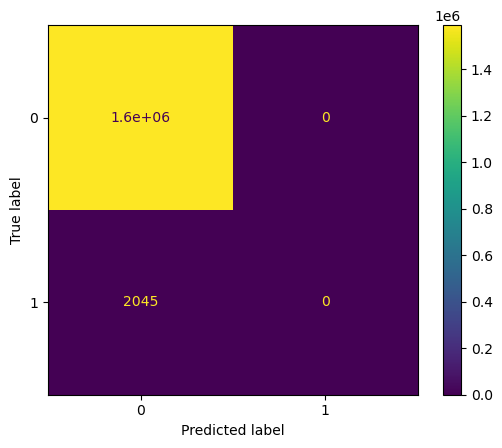

In [22]:
# Create the confusion matrix
cm = confusion_matrix(y_test, dtc_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

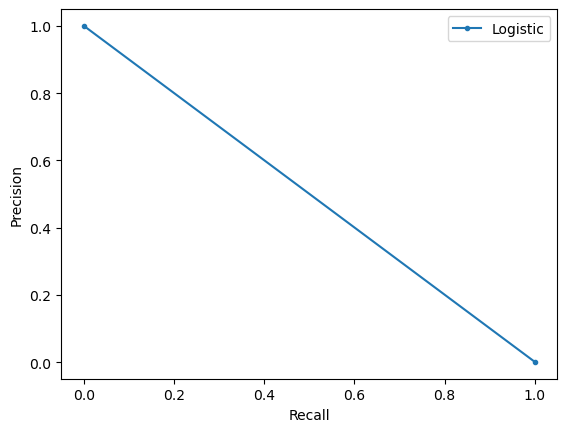

AUC PR: 0.501


In [23]:
# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, dtc_prob[:, 1])

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

#### 4.2 SMOTE

In [24]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
print(imblearn.__version__)

0.11.0


#### 4.2.1 Model Development

In [25]:
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.3, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [26]:
random_grid = {'model__criterion': ['gini', 'entropy', 'log_loss'],
               'model__splitter': ['best', 'random'],
               'model__max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'model__min_samples_split': [2, 5, 10],
               'model__min_samples_leaf': [1, 2, 4],
               'model__max_features': ['sqrt', 'log2', None],
               'model__ccp_alpha': [x/10 for x in range(1, 101)]}

#### 4.2.2 Training

In [27]:
m_smote = RandomizedSearchCV(pipeline, param_distributions = random_grid, n_iter = 100, cv = 5, 
                             verbose=0, random_state=42, n_jobs = -1, scoring='roc_auc')

m_smote.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('over',
                                              SMOTE(sampling_strategy=0.3)),
                                             ('under',
                                              RandomUnderSampler(sampling_strategy=0.5)),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__ccp_alpha': [0.1, 0.2, 0.3, 0.4,
                                                             0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0, 1.1, 1.2,
                                                             1.3, 1.4, 1.5, 1.6,
                                                             1.7, 1.8, 1.9, 2.0,
                                                             2.1, 2.2, 2.3, 2.4,
                                                             2.5, 2.6, 2.7, 2.8,
                                                             2.9, 3.0, ...],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [28]:
best_dtc_smote = m_smote.best_estimator_
m_smote.best_estimator_

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.3)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.1, criterion='entropy',
                                        max_depth=80, min_samples_leaf=2,
                                        min_samples_split=5))])

In [29]:
# Generate predictions with the best model
dtc_smote_pred = best_dtc_smote.predict(X_test)
dtc_smote_prob = best_dtc_smote.predict_proba(X_test)

#### 4.2.3 Performance

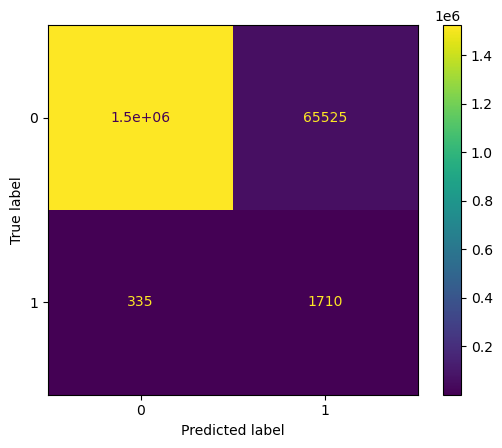

In [30]:
# Create the confusion matrix
cm = confusion_matrix(y_test, dtc_smote_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

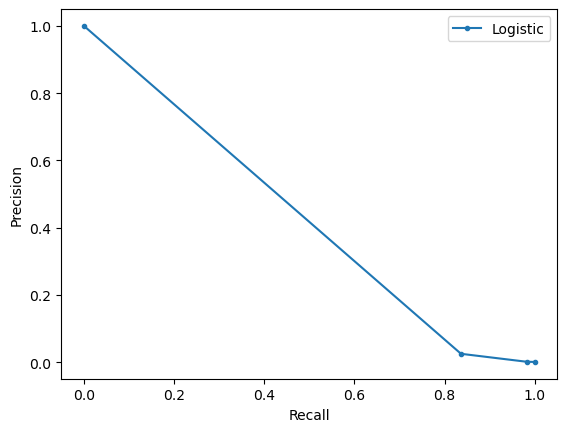

AUC PR: 0.431


In [31]:
# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, dtc_smote_prob[:, 1])

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

## 5. Discussion